### Artifical Neural Network Image Classifier Project

**Goal:** 
Outside the notebook: Take at least 100 images of several different objects using the 'imageclassifier' program. In this case, the objects/classes are 'cup', 'mocha', 'spray bottle' and 'bottle'. Create a neural network classification model to predict whether a new image belongs to one of the classes. 

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

#### Load image dataset

In [33]:
def load_images(base_path, classes):
    """
    Loads images from different classes into X and said classes into y.
    """
    X_list = [] # images as arrays
    y_list = [] # classes
    
    for class_ in classes:
        # Call the image files from each class folder
        files = os.listdir(base_path+class_)
        
        for file in files:
            # Load image
            im = image.load_img(path=base_path+class_+'/'+f'{file}', target_size=(224,224))
            # Convert image into an array
            numpy_image = np.array(im)
            # Convert color channels from BGR to RGB
            image_rgb = cv2.cvtColor(numpy_image, cv2.COLOR_BGR2RGB)
            # Reshape image
            image_rgb.reshape(1, 224, 224, 3)
            # Pre-process image
            processed_image = preprocess_input(image_rgb)
            # Append images to X and classes to y
            X_list.append(processed_image)
            y_list.append(class_)
        
    X = np.array(X_list)
    y = np.array(y_list)
    
    # Shuffle the data
    shuffler = np.random.permutation(len(X))
    X = X[shuffler]
    y = y[shuffler]
    
    return X, y

In [34]:
# Define base path and image classes
base_path = '/Users/happyflower/Desktop/spiced_2022/costmary-function-student-code/wk9_deep_learning/pics/'
classes = ['bottle', 'cup', 'mocha', 'spray_bottle']

In [35]:
# Define X and y - images as numpy arrays and their classes
X, y = load_images(base_path, classes)

In [36]:
X.shape, y.shape

((495, 224, 224, 3), (495,))

#### Transform y into categorical data

In [37]:
# Assign numbers to classes
y = pd.Series(y).map({classes[0]:0, classes[1]:1, classes[2]:2, classes[3]:3})

In [38]:
# Transform classes into one-hot-encoded categorical arrays
y = tf.keras.utils.to_categorical(
    y, num_classes=4, dtype='float32'
)

In [39]:
y.shape

(495, 4)

#### Split data into train and test sets

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=10)

#### Build neural network with pre-trained model in the base

In [41]:
# Start by clearing session
K.clear_session()

In [49]:
# Define pre-trained base model 'VGG16'
base_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)

In [50]:
# Check base model parameters
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [51]:
# Freeze layers in pre-trained model so they are not trainable
for layers in base_model.layers[:]: 
    layers.trainable = False

In [53]:
# Get features vector for base model predictions
features_vector = base_model.predict(X)
features_vector.shape

(495, 7, 7, 512)

In [54]:
# Verify the shape of array
X.shape

(495, 224, 224, 3)

#### Define & compile new model

In [104]:
K.clear_session()

In [105]:
# Define new model using pre-trained model as base
new_model = Sequential([
    
    # Base model VGG16
    base_model,
    
    # Flatten layer
    Flatten(),
    
    # Added ReLU layer
    Dense(100, activation='relu'),
    
    # Softmax output layer
    Dense(4, activation='softmax')
])

In [106]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2508900   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 17,223,992
Trainable params: 2,509,304
Non-trainable params: 14,714,688
_________________________________________________________________


In [107]:
# Compile model
new_model.compile(loss=binary_crossentropy,
                  optimizer=Adam(learning_rate=1e-5),
                  metrics=['accuracy']
                 )

#### Train new model

In [108]:
# Fit model to training data with cross-validation
history = new_model.fit(X_train, y_train, 
                        batch_size=35, 
                        epochs=12, 
                        validation_split=0.2)

Epoch 1/8
9/9 [==============================] - 104s 11s/step - loss: 0.6857 - accuracy: 0.2534 - val_loss: 0.5827 - val_accuracy: 0.2533
Epoch 2/8
9/9 [==============================] - 100s 11s/step - loss: 0.5549 - accuracy: 0.3615 - val_loss: 0.5087 - val_accuracy: 0.5200
Epoch 3/8
9/9 [==============================] - 97s 11s/step - loss: 0.4880 - accuracy: 0.6554 - val_loss: 0.4590 - val_accuracy: 0.7467
Epoch 4/8
9/9 [==============================] - 111s 13s/step - loss: 0.4342 - accuracy: 0.8243 - val_loss: 0.4123 - val_accuracy: 0.8400
Epoch 5/8
9/9 [==============================] - 95s 11s/step - loss: 0.3850 - accuracy: 0.9155 - val_loss: 0.3695 - val_accuracy: 0.8933
Epoch 6/8
9/9 [==============================] - 96s 11s/step - loss: 0.3398 - accuracy: 0.9628 - val_loss: 0.3306 - val_accuracy: 0.9067
Epoch 7/8
9/9 [==============================] - 137s 16s/step - loss: 0.3004 - accuracy: 0.9730 - val_loss: 0.2967 - val_accuracy: 0.9733
Epoch 8/8
9/9 [===============

#### Plot results

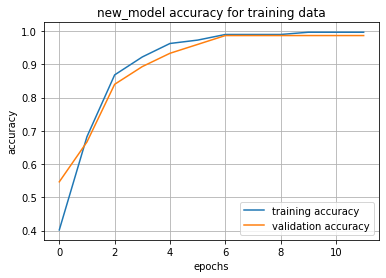

In [99]:
# Plot accuracy for training data
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label= 'validation accuracy')
plt.title('new_model accuracy for training data')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

# Accuracy maxes out 98.67% by 7th epoch (labelled here as 6 since values start from 0)

(-0.01, 1.0)

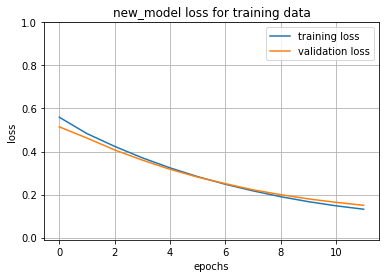

In [96]:
# Plot loss for training data
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label= 'validation loss')
plt.title('new_model loss for training data')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.gca().set_ylim(-0.01,1)

# Loss drops below 0.2 at 9th epoch

In [100]:
# Run model on test data - loss, accuracy
new_model.test_on_batch(X_test, y_test)

[0.16143517196178436, 0.9597989916801453]

**Improvements:** The model could be improved by minimizing the number of epochs to point at which accuracy maxes out.

#### Save model

In [109]:
new_model.save('vgg16_relu_softmax.h5')

**Next step:** Outside the notebook, run the separate 'imageclassifier' program in the console and use the model to predict classes for images captured on the webcam.

#### Bonus: Example of classifying image

In [181]:
# Load an example image from 'cup' class
im = image.load_img(base_path+'cup/'+'15-50-25-601474.png', target_size=(224, 224))

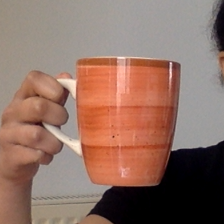

In [182]:
# Verify the image is correct
im

In [216]:
# Process image
a = image.img_to_array(im)
a = preprocess_input(a)
a = a.reshape(1, 224, 224, 3)

In [217]:
# Verify shape of image array
a.shape

(1, 224, 224, 3)

#### Define MobileNetV2 model

In [ ]:
K.clear_session()

In [178]:
# Use the MobileNetVs model for this example to try something different
m = MobileNetV2(weights='imagenet', include_top=True)
m.summary()

14548992/14536120 [==============================] - 17s 1us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_____________

#### Make class prediction for example image

In [219]:
prediction = m.predict(a)
pprint(decode_predictions(prediction, 10))
# cup is correct and is predicted here as most likely, although with low confidence

[[('n07930864', 'cup', 0.18471503),
  ('n04263257', 'soup_bowl', 0.1477101),
  ('n03443371', 'goblet', 0.06484265),
  ('n03063599', 'coffee_mug', 0.061506562),
  ('n03733805', 'measuring_cup', 0.05063495),
  ('n03786901', 'mortar', 0.04217356),
  ('n03991062', 'pot', 0.041612323),
  ('n02795169', 'barrel', 0.02220935),
  ('n07920052', 'espresso', 0.020532105),
  ('n03920288', 'Petri_dish', 0.019988073)]]


#### Visualize intermediate outputs

In [200]:
# Checking output of 4th layer as example
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=[
                                     model.get_layer(index=2).output,
                                     model.get_layer(index=4).output
                                 ])

cnn2, cnn4 = intermediate_layer_model.predict(a)
cnn2.shape, cnn4.shape

((1, 27, 27, 16), (1, 2704))

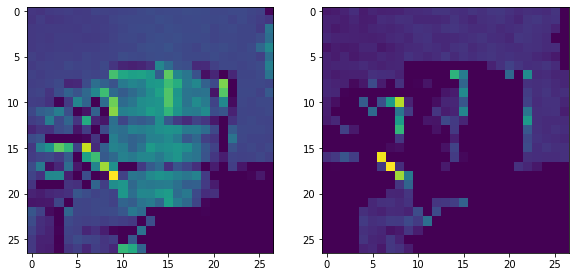

In [202]:
# Visualize feature maps at 4th layer
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cnn2[0,:, :, 0])
plt.subplot(1, 3, 2)
plt.imshow(cnn2[0,:, :, 1])